In [1]:
import requests
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
%matplotlib inline

datafolder = 'workdata'
paysdf = {}

In [2]:
# LOAD tables
payslist = ['France','Germany','Italy','Spain','Belgium','United Kingdom']
for paysname in payslist:
    filepath = datafolder+'/incidence_'+paysname+'_Table.csv'
    paysdf[paysname] = pd.read_csv(filepath)

testdf = paysdf['France']
testdf

,Confirmed,Deaths,Recovered,Active,Date,Confirmed_Incidence,Active_Incidence,Deaths_Incidence,Recovered_Incidence
0,0,0,0,0,2020-01-22 00:00:00,0.000000,0.000000,0.000000,0.000000
1,0,0,0,0,2020-01-23 00:00:00,0.666667,0.666667,0.000000,0.000000
2,2,0,0,2,2020-01-24 00:00:00,1.000000,1.000000,0.000000,0.000000
3,3,0,0,3,2020-01-25 00:00:00,1.000000,1.000000,0.000000,0.000000
4,3,0,0,3,2020-01-26 00:00:00,0.333333,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
293,1857309,41062,135216,1681031,2020-11-10 00:00:00,26577.000000,24180.000000,703.000000,1694.000000
294,1914918,42599,139177,1733142,2020-11-11 00:00:00,19663.333333,17814.666667,516.666667,1332.000000
295,1915282,42599,139212,1733471,2020-11-12 00:00:00,19456.000000,17480.000000,512.666667,1514.666667
296,1915677,42600,139760,1733317,2020-11-13 00:00:00,265.000000,121.666667,0.333333,194.333333


# ESTIMATION OF R PROCESS

In [3]:
# =============================
#  PREDEFINED PARAMETERS
# =============================
# A - TYPE OF CALCULATION
UNCERTAINTY_FLAG = False
# FALSE will build the SI_distribution with only 'main' fixed values of input mean and std, it is fairly quick
# TRUE will build SI_distribution by iterating to find most probable value of MEAN and STD around main value,
# it is a lot slower

# PARAMETERS TO BUILD THE SERIAL INTERVAL DISTRIBUTION
# MAIN VALUES : mandatory for all types of computation
SI_mean = 8.4
SI_stdev = 3.8

# UNCERTAINTY DISTRIBUTION PARAMETERS
mean_vars = {'std':1,
             'MAX':12.4,
             'min':4.4}
stdev_vars = {'std':0.5,
            'MAX':5.8,
            'min':1.8}

uncertaintySampleSize = 5
posteriorSamplesize = 5

# LOOOOOOTS of verifications to implement about these values !!

# TIME INTERVALS FOR COMPUTATION
# DETERMINE STARTING POINT : low values will skip more of the first days for computation
CVThreshold = 0.3 
# ComputationLength : average of R computation over a time frame (7 = average on 1 week)
ComputationLength=7
# ComputationStep >> 1 = every day ; 7 = every weeks
ComputationStep=1

#Prior starting values of mean/std
MeanPrior = 5
StdPrior = 5

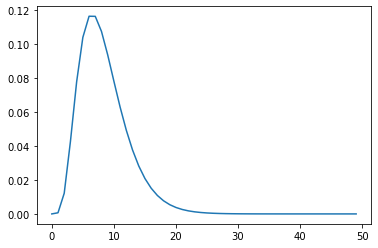

In [4]:
from utils_R import FinalSIDistributionWithoutUncertainty

visuMeanSIFinal,visusdSIFinal,visuSIDistr = FinalSIDistributionWithoutUncertainty(SI_mean,SI_stdev,50)
plt.plot(range(50),visuSIDistr)

In [5]:
# INCIDENCE SERIE (supplementary cases per days column)
# can be mesured on confirmedcases, hostitalisation cases, or reanimation cases
# as long as there is NO negative values

IncidenceSerie = testdf['Confirmed_Incidence']  
TimeMaxnb = IncidenceSerie.shape[0]    
print('length of current time serie : {} days'.format(TimeMaxnb))

length of current time serie : 298 days


## PREPARATION FUNCTIONS

In [6]:
# FUNCTION - 1  : PRIOR SI DATA
# FUNCTION - 2  : STARTING TIME FRAME
# FUNCTION - 3 : TIME STEPS DEFINITION

# verif to get out of function (prior to call)
#if CurrentCalcLength < 1 :
#    print("You cannot estimate R over a period shorter than the time step of your data. Estimation aborted.")
#    return False
#elif CurrentCalcLength > TimeMaxnb:
#    print("You cannot estimate R over a period longer than the epidemic. Estimation aborted.")
#    return False
#elif CurrentTimeStep < 1 :
#    print("The number of time steps at which estimation is performed must be an integer >=1. Estimation aborted.")
#    return False

# FUNCTION - 4 : DiscreteShifted Gamma SIDistr

# FUNCTION - 5 - serial interval definition

# PRIOR verif to do on MEAN and STD
# "The mean serial interval must be >1 time step of incidence. Estimation aborted."
# "The std of the serial interval must be >=0. Estimation aborted."

# POSTERIOR VERIF 
# SIDistr <> 0 : "serial interval distribution at time 0 is not null. Our model does not account for the possibility that index cases infect individuals on the very day when they are infected ! Estimation aborted."
# any SIDistr value < 0 : "serial interval distribution at time " & t & " is negative. Estimation aborted."
# SumPi < 1 : "Error: the serial interval distribution you provided does not sum to 1. Estimation aborted."

# MeanSIFinal < 1 :"The parameters you provided lead to a mean discrete serial interval <1 time step of incidence. Estimation aborted."


# FUNCTION - 6 & 7 : LAMBDA & CALCULATE POSTERIOR

#EXEC TEST
#testposterior = CalculatePosterior(testIncidenceSerie, aPrior, bPrior, SI_mean, SI_stdev, range(12,18))
#testposterior = CalculatePosterior(testIncidenceSerie, aPrior, bPrior, SI_mean, SI_stdev, range(25,35))
#print(testposterior)
#print(testposterior[0] * testposterior[1]) # TEST VALUE : 1.52470320666128
#print(math.sqrt(testposterior[0]) * testposterior[1]) # TEST VALUE : 0.539063988363533

#LambdaCalc(20, SImean,SIstdev, IncidenceSerie)


# FUNCTION - 8 : COMPUTE MU & SIGMA SAMPLE ON UNCERTAINTY PARAMETERS
# lots of verification to add about this one

#mu,sigma = compute_mu_sigma_distrib(samplesizeperSIdistr,SI_mean,SI_stdev,mean_vars,stdev_vars)
#fig = plt.figure(figsize=(10, 5))
#plt.scatter(mu,sigma)

from utils_R import get_abPrior, \
search_StartingTimeStep, \
get_TimeStepSlices, \
DiscreteShiftedGammaSIDistr, \
FinalSIDistributionWithoutUncertainty, \
LambdaCalc, \
CalculatePosterior, \
compute_mu_sigma_distribution
                    

def getTimeSteps_custom(): pass

In [8]:
# EXEC TEST
from TEST_utils_R import launch_utils_R_TESTS
launch_utils_R_TESTS()

STARTING TESTS ON UTILS_R FUNCTION
TEST get_abPrior : OK
TEST search_starting_timestep : starting
ERROR : The epidemic is too small to ever get the desired posterior CV. Estimation aborted. Try a higher value for the aimed posterior CV.
TEST search_starting_timestep : OK
TEST get_TimeStepSlices : starting
ERROR : The epidemic is too small to ever get the desired posterior CV. Estimation aborted. Try a higher value for the aimed posterior CV.
TEST get_TimeStepSlices : OK
TEST DiscreteShiftedGammaSIDistr : OK
TEST TEST_FinalSIDistributionWithoutUncertainty : OK


In [9]:
# =============================
# R ESTIMATION 
# =============================
# local VARS 
aPosterior=[]
bPosterior=[]
MeanR=[]
StdR=[]
RQuantile025=[]
RQuantile05=[]
RQuantile25=[]
Rmedian=[]
RQuantile75=[]
RQuantile95=[]
RQuantile975=[]

# STEP 1
aPrior,bPrior = get_abPrior(MeanPrior,StdPrior)
CumulIncThreshold = 1 / (CVThreshold * CVThreshold) - aPrior
# Time steps
startTime,endTime = get_TimeStepSlices(IncidenceSerie,CumulIncThreshold,
                                 ComputationLength,ComputationStep)
# VERIF 
#  If (endTime(TimePeriodNb - 1) < StartEstimDate) : 
#    "Warning: you are trying to estimate R too early in the epidemic to get the desired posterior CV. Estimation will be performed anyway."
#  If any startTime[x] > endTime[x]) : "Time period X has its starting date after its ending date. Estimation aborted."
#  if any endTime[x] > TimeMaxnb : "Time period X ends after the end of the epidemic.  Estimation aborted.    

In [10]:
#computation visualization variable
compviz = len(startTime)/10
i = 0
j = 1

if not UNCERTAINTY_FLAG:
    # =============================
    # R ESTIMATION WITHOUT UNCERTAINTY
    # =============================
    # SERIAL INTERVAL DISTRIB
    MeanSIFinal,sdSIFinal,SIDistr = FinalSIDistributionWithoutUncertainty(SI_mean,SI_stdev,TimeMaxnb)
    # VERIF 
    #  If (endTime(TimePeriodNb - 1) < StartEstimDate) : 
    #    "Warning: you are trying to estimate R too early in the epidemic to get the desired posterior CV. Estimation will be performed anyway."
    #  If any startTime[x] > endTime[x]) : "Time period X has its starting date after its ending date. Estimation aborted."
    #  if any endTime[x] > TimeMaxnb : "Time period X ends after the end of the epidemic.  Estimation aborted.    

    # LOOP ON TIME PERIODS
    for curStart,curEnd in zip(startTime,endTime) :
        #Compute A & B posterior
        TimePeriodRange = range(curStart,curEnd)
        #print(TimePeriodRange)
        result = CalculatePosterior(IncidenceSerie,aPrior, bPrior, SI_mean, SI_stdev, TimePeriodRange)
        aPosterior.append(result[0])
        bPosterior.append(result[1])

        # compute mean and std using last computed a and b 
        MeanR.append(aPosterior[-1] * bPosterior[-1])
        StdR.append(math.sqrt(aPosterior[-1]) * bPosterior[-1]) 

        RQuantile025.append(stats.gamma.ppf(0.025, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile05.append(stats.gamma.ppf(0.05, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile25.append(stats.gamma.ppf(0.25, aPosterior[-1], scale=bPosterior[-1]))
        Rmedian.append(stats.gamma.ppf(0.5, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile75.append(stats.gamma.ppf(0.75, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile95.append(stats.gamma.ppf(0.95, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile975.append(stats.gamma.ppf(0.975, aPosterior[-1], scale=bPosterior[-1]))

        if i > compviz :
            compviz = compviz + len(startTime)/10
            print('{}0% complete'.format(j))
            j=j+1
        i=i+1
           
else : 
    # =============================
    # R ESTIMATION WITH UNCERTAINTY
    # =============================
    # COMPUTE UNCERTAINTY SAMPLE
    mu,sigma = compute_mu_sigma_distribution(uncertaintySampleSize,SI_mean,SI_stdev,mean_vars,stdev_vars)

    # LOOP ON TIME PERIODS
    for curStart,curEnd in zip(startTime,endTime) :
        #Compute A & B posterior
        TimePeriodRange = range(curStart,curEnd)
        #print(TimePeriodRange)   

        SampleR = []
        aPosterior_cur = []
        bPosterior_cur = []
        # LOOP ON SAMPLESIZE
        for k in range(len(mu)):
            result = CalculatePosterior(IncidenceSerie,aPrior, bPrior, mu[k], sigma[k], TimePeriodRange)    
            aPosterior_cur.append(result[0])
            bPosterior_cur.append(result[1])

            SampleR_curloop = []
            for l in range(posteriorSamplesize):
                SampleR_curloop.append(stats.gamma.ppf(np.random.random(), 
                                                       aPosterior_cur[-1],
                                                       scale=bPosterior_cur[-1]))

            SampleR.append(SampleR_curloop)
        sampleRprint = np.array(SampleR)

        # compute mean and std using last computed a and b 
        MeanR.append(np.mean(sampleRprint))
        StdR.append(np.std(sampleRprint))
        aPosterior.append(np.mean(aPosterior_cur))
        bPosterior.append(np.mean(bPosterior_cur))

        percentiles = np.percentile(sampleRprint,[2.5,5,25,50,75,95,97.5])

        RQuantile025.append(percentiles[0])
        RQuantile05.append(percentiles[1])
        RQuantile25.append(percentiles[2])
        Rmedian.append(percentiles[3])
        RQuantile75.append(percentiles[4])
        RQuantile95.append(percentiles[5])
        RQuantile975.append(percentiles[6])

        if i > compviz :
            compviz = compviz + len(startTime)/10
            print('{}0% complete'.format(j))
            j=j+1
        i=i+1
        
print('computation complete')

10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete


In [13]:
# DATAFRAMING RESULTS
testdict = {'timestep':endTime,
            'aPosterior':aPosterior,
            'bPosterior':bPosterior,
            'MeanR':MeanR,
            'StdR':StdR,
            'RQuantile025':RQuantile025,
            'RQuantile05':RQuantile05,
            'RQuantile25':RQuantile25,
            'Rmedian':Rmedian,
            'RQuantile75':RQuantile75,
            'RQuantile95':RQuantile95,
            'RQuantile975':RQuantile975}

rsltdf = pd.DataFrame(testdict)

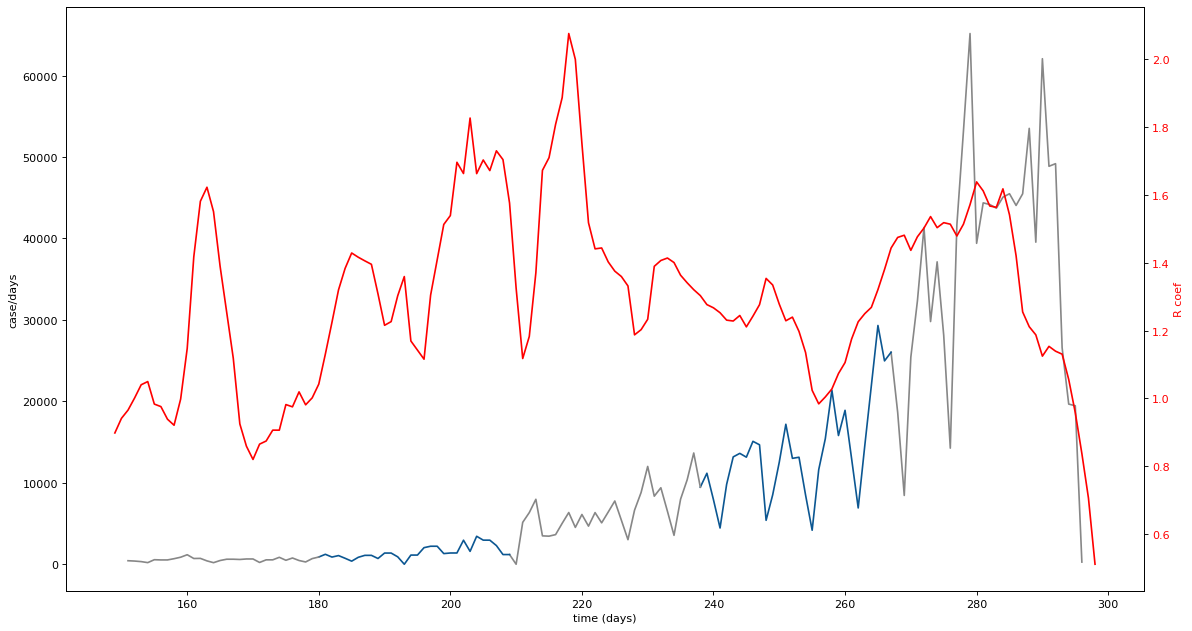

In [14]:
from matplotlib.pyplot import figure

# VISUALISATION
rangeselection = 150
if rangeselection <= IncidenceSerie.shape[0] :
    index = IncidenceSerie.shape[0]-rangeselection
else : index = 0
#print(index)

Rtable = rsltdf[['timestep','MeanR']].loc[rsltdf['timestep'] > index]

# X inc sections CONSTRUCTION
xsections = []
incsections =[]
rangesection = 30 # 30 = month ; 7 = week

lastvalue = IncidenceSerie.shape[0]-1
i=1

while True:
    startval = max(lastvalue-rangesection,0)
    if startval < index : break
    x = np.array(range(startval,lastvalue))
    
    #r = y2[startval:lastvalue]
    i = IncidenceSerie[startval:lastvalue]
    xsections.append(x)
    #Rsections.append(r)
    incsections.append(i)
    lastvalue = startval+1
    if startval == 0 : break

#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots(figsize=(15, 8), dpi=80)

ax1.set_xlabel('time (days)')
ax1.set_ylabel('case/days')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('R coef',color='red')  # we already handled the x-label with ax1

colors = ['#878787', '#0c5792']
for i,val in enumerate(xsections):
    ax1.plot(xsections[i], incsections[i], color=colors[i%2]) # plt.plot(x, y, "y-", color=colors[i%2])

#ax1.tick_params(axis='y', labelcolor=color)
ax2.plot(Rtable['timestep'], Rtable['MeanR'], color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()